# Using Pytorch Autograd to optimize regression on the Iris dataset

This Notebook is to practice using Pytorch's Autograd to minimize the regression loss function on the iris dataset.

The iris datset is imported from [sci-kit learn](https://www.geeksforgeeks.org/iris-dataset/).

#### **Acknowledgment**
This was inspired by Jon Krohn's demo on optimizing linear regression.
- [Part 1](https://www.youtube.com/watch?v=AaUv2p0lSKU)
- [Part 2](https://www.youtube.com/watch?v=W-aiTln22cA&t=2139s)

## A. Background

Pytorch's Autograd, or automatic differentiation (AD), is a way to calculate the gradient of a function quickly and automatically.


### Less technical explanation
References:
1. [Computerphile video on Forward AD and dual number](https://www.youtube.com/watch?v=QwFLA5TrviI)
2. [Jon Krohn's video on AD](https://www.youtube.com/watch?v=I7BviziWMiw)
3. [Jon Krohn's demo using Pytorch](https://www.youtube.com/watch?v=Okwa-URH1cs)
4. [A Gentle Introduction to `torch.autograd`](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html?utm_source=pytorchkr)

When computing the gradient or derivative of a function, there are several ways of doing it.
1. _Symbolic differentiation_: Students memorize rules on how teach type of function changes during the differentiation process. This is time consuming because of [*expression swelling*](https://youtu.be/wG_nF1awSSY?si=dssE3zKfxNxMVk5b&t=193), where rules like the product rule balloons the number of terms with increasing complexity. Also, the functions must be closed loop forms, so cannot use for loops or recursion.  
2. _Numerical differentiation_: Using discretized data points to calculates the secants of the function. This as the interval between data points get finer, the secant will be a good approximation of the tangent (i.e. decreasing truncation error). However, because floating points of very small numbers induce rounding errors, this is not a good idea. The true drawback is that for a function that has n number of inputs, the program has to calculate the derivative n times (O(n) time complexity), and the model training process becomes impractical.
3. Automatic differentiation: consists of two versions: forward and reverse modes. The forward mode calculates the value of the intermediary functions and the tangent at the intermediary function for a set of given input value using the chain rule. The chain rule in calculus is applied from the most-nested function, but AD proceeds from the outermost function inward (_reverse mode_) The reverse mode is only slightly more computationally expensive (constant factor) than the forward pass.
$$ \frac{df(x)}{dx}\ = \frac{df}{du}\ \frac{du}{dx}\ $$
- Forward pass: from input $x$ to intermediary function $u$ to final function $f$
- Reverse pass: from value of the function $f$, calculate the value of $u$ then the value of $x$

Steps:
1. `import torch` and set input parameter as `a = torch.tensor(2.0, requires_grad=True)`. The input parameter has to be float, and it can be any number, not just 2.0. For this example, let's assume that there are two input tensor variables, `a` and `b`
2. Create another tensor: `y = a**2 + b`. The value of `y` is calculated based on the inputs `a` and `b` in step 1.
3. `y.backward()` uses Pytorch's autograd function that stores the _gradients_ $\frac{\partial y}{\partial a}\ = 2a$ and $\frac{\partial y}{\partial b}\ = 1$ in tensors `a` and `b`'s `.grad` attributes. The gradients are stores in respective inputs because in a neural network, we want the error `y` with respect to each input parameter `a` and `b`.
4. To access the gradient values, use `a.grad` and `b.grad`.


In [ ]:
import torch

a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(5., requires_grad=True)
y = a**2 + b

y.backward()
print(f'calculated y-value from the inputs is {y}')
print(f'gradient of y w.r.t. a is {a.grad}')
print(f'gradient of y w.r.t. b is {b.grad}')

calculated y-value from the inputs is 9.0
gradient of y w.r.t. a is 4.0
gradient of y w.r.t. b is 1.0


### Slightly technical explanation
References:
1. [Ari Seff's explanation](https://www.youtube.com/watch?v=wG_nF1awSSY)
2. [Pytorch documentation](https://docs.pytorch.org/docs/stable/notes/autograd.html)
3. [Jonathan Hare lecture notes](https://drive.google.com/file/d/1aVEO76BGUD_L1wWFzYP4UN_P-ycJrwNJ/view?usp=drive_link)
4. [`torch.autograd` subfunctions](https://docs.pytorch.org/docs/stable/autograd.html)


The technical explanation requires learning about [vector calculus and Jacobian](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#optional-reading-vector-calculus-using-autograd).

## B. Implementation

Objective: based on a set of widths and lengths, can you create a linear regression line that predicts the length using width as the input? Use RMSE as the loss function. Use Pytorch's Autograd to find the best fit.


Note: feature scaling is omitted because it's a linear regression with one input variable

In [ ]:
!pip install -q torchviz

In [ ]:
import torch
from torchviz import make_dot
import numpy as np

# Data
from sklearn.datasets import load_iris
# https://www.geeksforgeeks.org/iris-dataset/

# RMSE will be implemented manually for practice
# from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']


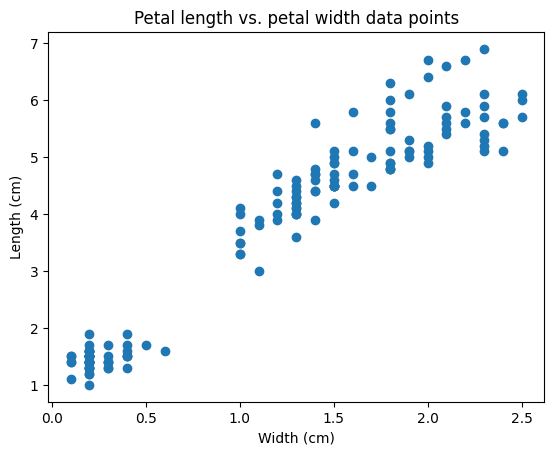

In [ ]:
# load the dataset
iris = load_iris()

# Feature names and target names
print(f"Feature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")

width = iris.data[:,3]
length = iris.data[:,2]

# Initial exploration of data points
fig, ax = plt.subplots()
plt.title('Petal length vs. petal width data points')
plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')
_ = ax.scatter(width ,length)

# The goal is to create a linear regression line that predicts the length based on width.

In [ ]:
X = torch.tensor(width) # petal width as independent variable (input)
y = torch.tensor(length) # petal length as dependent variable (output)

# Omitting feature scaling because it's a linear regression with 1 variable

In [ ]:
# Since we're going for a linear regression model that fits y = mx + b format
# initialize the model by using m = -0.5 and b = -0.9
# Just some "random" numbers that are clearly very wrong according to the above plot.
# Wrong numbers are deliberately chosen to see how the model gets optimized.

m = torch.tensor([-0.5], requires_grad=True)
b = torch.tensor([-0.9], requires_grad=True)

In [ ]:
# Define a function for linear regression: y_regression = m*X + b
def lin_reg(x, m, b):
  return m*x+b

In [ ]:
# showing the regression line on a plot
def lin_reg_plot(x, y, m, b):
  # Raises run time error if a tensor is passed in.
  # Cannot process tensors set to requires_grad = True.
  m = m.detach().numpy()
  b = b.detach().numpy()

  fig, ax = plt.subplots()
  plt.title(f'm = {m}, b = {b}')
  plt.xlabel('Width (cm)')
  plt.ylabel('Length (cm)')
  ax.scatter(x, y)

  x_min, x_max = ax.get_xlim()
  y_min = m*x_min + b
  y_max = m*x_max + b

  ax.set_xlim([x_min, x_max])
  _ = ax.plot([x_min, x_max], [y_min, y_max])

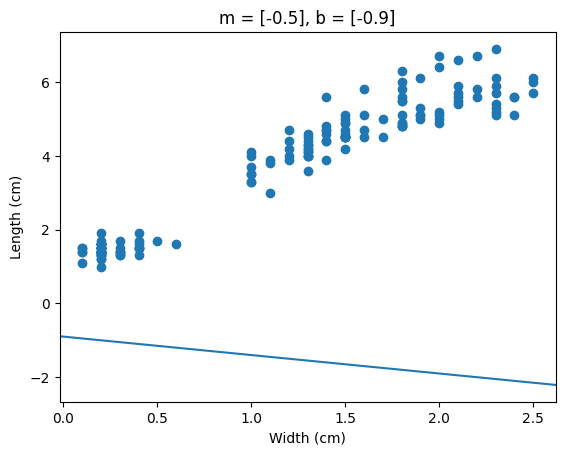

In [ ]:
lin_reg_plot(X, y, m, b)

Looks like the linear regression line does not fit the data well.
Let's use RMSE as a loss function to progressively sweak `m` and `b` to fit the data better.

In [ ]:
def rmse(y_data, y_regression):
  diff_sum = torch.sum((y_data - y_regression)**2)
  mse = diff_sum/(len(y_regression))
  return torch.sqrt(mse)

In [ ]:
loss = rmse(y, lin_reg(X, m, b))

In [ ]:
loss.backward()

In [ ]:
# # Visualize the computation graph
# dot = make_dot(y, params={"x": X, "y": y, "m": m, "b": b})
# dot.render("grad_computation_graph", format="png")

# img = plt.imread("grad_computation_graph.png")
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [ ]:
print(f'RMSE: {loss}')
print(f'Partial derivative of RMSE w.r.t. m is {m.grad}')
print(f'Partial derivative of RMSE w.r.t. b is {b.grad}')

RMSE: 5.67184418121316
Partial derivative of RMSE w.r.t. m is tensor([-1.3895])
Partial derivative of RMSE w.r.t. b is tensor([-0.9270])


Using `m = -0.5` and `b = -0.9`:
- $ \frac{∂(RMSE)}{∂m}\ = -1.3895 $, which means that increasing the value of $m$ will lower the error (RMSE).

- $ \frac{∂(RMSE)}{∂b}\ = -0.9270 $, same for $b$

Therefore, for the next step of the iteration, try using higher $m$ and $b$ values and repeat the process.


The question is how much should we increase the value of $m$ and $b$?

There are more intricate ways to do this, but the purpose of this tutorial is to introduce the usage of Autograd, so we'll just use [**stochastic gradient descent**](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html).

In [ ]:
# Gradient descent

# initialize
optimizer = torch.optim.SGD([m,b], lr = 0.01)
# learning rate defines how much the optimizer tweaks the model parameters m and b

In [ ]:
optimizer.step()
# This will adjust the model parameters

In [ ]:
print(f'New m: {m}')
print(f'New b: {b}')

New m: tensor([-0.4861], requires_grad=True)
New b: tensor([-0.8907], requires_grad=True)


  The new $m$ and $b$ values are larger than the initial values, -0.5 and -0.9, respectively.

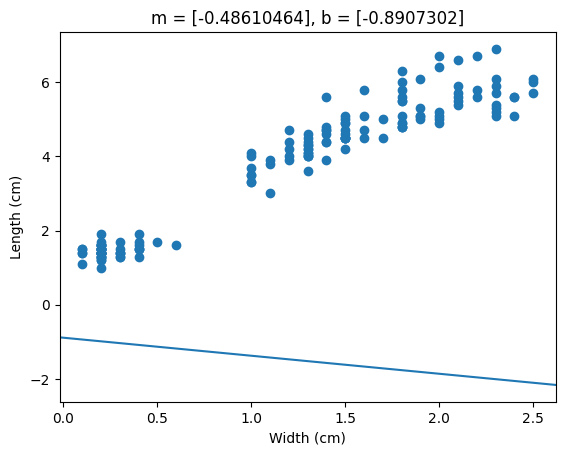

In [ ]:
lin_reg_plot(X,y,m,b)

In [ ]:
loss = rmse(y, lin_reg(X, m, b))
print(f'New RMSE: {loss}')

New RMSE: 5.643943702668129


New RMSE is lower than the first RMSE, which was 5.67184418121316

In [ ]:
# epoch is iteration step
epochs = 1000

# To log the values
rmse_log = []
m_log = []
b_log = []


for epoch in range(epochs):
  optimizer.zero_grad() # reset gradients to zero to save memory. Otherwise, they accumulate

  m_log.append(float(m.detach()))
  b_log.append(float(b.detach()))

  loss = rmse(y, lin_reg(X, m, b))
  rmse_log.append(float(loss.detach()))


  loss.backward()
  optimizer.step()

  print(f'Epoch {epoch}; RMSE {loss}; m_grad {m.grad}; b_grad {b.grad}')

Epoch 0; RMSE 5.643943702668129; m_grad tensor([-1.3895]); b_grad tensor([-0.9270])
Epoch 1; RMSE 5.6160452045596125; m_grad tensor([-1.3894]); b_grad tensor([-0.9270])
Epoch 2; RMSE 5.588148743150496; m_grad tensor([-1.3893]); b_grad tensor([-0.9269])
Epoch 3; RMSE 5.560254347433873; m_grad tensor([-1.3893]); b_grad tensor([-0.9269])
Epoch 4; RMSE 5.532362019018512; m_grad tensor([-1.3892]); b_grad tensor([-0.9269])
Epoch 5; RMSE 5.504471815067326; m_grad tensor([-1.3891]); b_grad tensor([-0.9269])
Epoch 6; RMSE 5.476583765505383; m_grad tensor([-1.3891]); b_grad tensor([-0.9269])
Epoch 7; RMSE 5.448697872889969; m_grad tensor([-1.3890]); b_grad tensor([-0.9269])
Epoch 8; RMSE 5.420814209204961; m_grad tensor([-1.3889]); b_grad tensor([-0.9269])
Epoch 9; RMSE 5.392932777678804; m_grad tensor([-1.3889]); b_grad tensor([-0.9268])
Epoch 10; RMSE 5.365053650984266; m_grad tensor([-1.3888]); b_grad tensor([-0.9268])
Epoch 11; RMSE 5.33717684691053; m_grad tensor([-1.3887]); b_grad tensor([

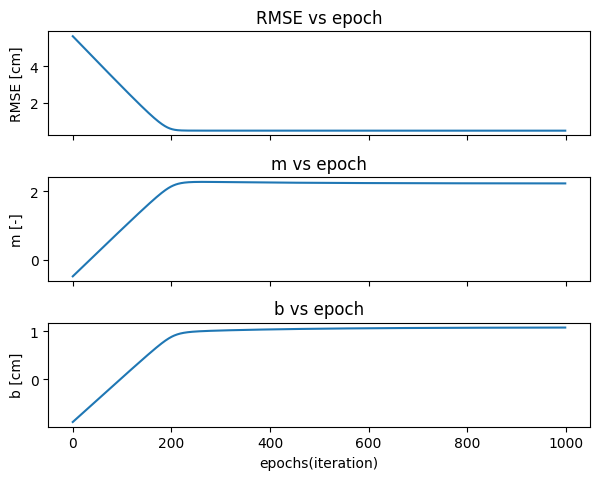

In [ ]:
# Plot RMSE, m, and b values w.r.t. epochs to see how they change over iterations
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.tight_layout(pad=2)

plt.subplot(3,1,1)
plt.title('RMSE vs epoch')
plt.ylabel('RMSE [cm]')
plt.plot(range(epochs), rmse_log)

plt.subplot(3,1,2)
plt.title('m vs epoch')
plt.ylabel('m [-]')
plt.plot(range(epochs), m_log)

plt.subplot(3,1,3)
plt.title('b vs epoch')
plt.ylabel('b [cm]')
plt.xlabel('epochs(iteration)')
plt.plot(range(epochs), b_log)

From the plots, it's shown that the RMSE achieves its lowest values (~0.475) at around 250-th epoch.

For sake of sanity, it's check the $R^2$ value

In [ ]:
y_final_prediction = lin_reg(X, m, b).detach().numpy()
r2_score(y, y_final_prediction)

0.9271089196723848

$R^2 = 0.927$

Pretty good.